In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=OPENAI_API_KEY
)


In [3]:
documents = [
    "LangGraph enables stateful, graph-based agent workflows.",
    "Re-ranking improves retrieval quality by reordering candidate documents.",
    "RAG combines document retrieval with language model generation.",
    "Vector similarity search may retrieve partially relevant documents."
]

In [4]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

vectorstore = FAISS.from_texts(
    documents,
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

In [5]:
from typing import TypedDict, List

class RerankState(TypedDict):
    question: str
    retrieved_docs: List[str]
    ranked_docs: List[str]
    answer: str

In [6]:
def retrieve_node(state: RerankState) -> RerankState:
    docs = retriever.invoke(state["question"])
    contents = [doc.page_content for doc in docs]

    return {
        **state,
        "retrieved_docs": contents
    }

In [7]:
def rerank_node(state: RerankState) -> RerankState:
    docs_text = "\n".join(
        [f"{i+1}. {doc}" for i, doc in enumerate(state["retrieved_docs"])]
    )

    prompt = f"""
You are a re-ranking agent.

Reorder the documents below by relevance to the question.
Return the reordered document numbers only, most relevant first.

Question:
{state['question']}

Documents:
{docs_text}
"""

    response = llm.invoke(prompt).content.strip()

    order = [int(i.strip()) - 1 for i in response.split(",") if i.strip().isdigit()]
    ranked = [state["retrieved_docs"][i] for i in order if i < len(state["retrieved_docs"])]

    return {
        **state,
        "ranked_docs": ranked
    }

In [8]:
def generate_node(state: RerankState) -> RerankState:
    context = "\n".join(state["ranked_docs"][:2])

    prompt = f"""
Answer the question using ONLY the context below.

Context:
{context}

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }

In [9]:
from langgraph.graph import StateGraph, END

graph = StateGraph(RerankState)

graph.add_node("retrieve", retrieve_node)
graph.add_node("rerank", rerank_node)
graph.add_node("generate", generate_node)

graph.set_entry_point("retrieve")

graph.add_edge("retrieve", "rerank")
graph.add_edge("rerank", "generate")
graph.add_edge("generate", END)

app = graph.compile()

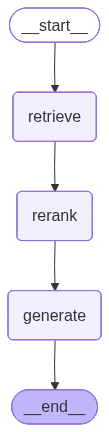

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [11]:
question = "what vector similarity does"

initial_state: RerankState = {
    "question": question,
    "retrieved_docs": [],
    "ranked_docs": [],
    "answer": ""
}

final_state = app.invoke(initial_state)

print("Answer:\n")
print(final_state["answer"])


Answer:

Vector similarity search retrieves documents based on their relevance to a query, but it may return partially relevant documents.
